# Generative Model with Variational AutoEncoder (VAE)

In [1]:
import numpy as np
import tensorflow as tf
import keras

import os
import datetime
import time as timer
import sys
import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import models as M
import utils as U

imp.reload(M)
imp.reload(U)

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_29910/2628687434.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'utils' from '/Users/mghifary/Work/Code/AI/keras-poc/utils.py'>

In [2]:
EPOCH = 30
BATCH = 128

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

### Load and preprocess data

In [3]:
# Load dataset
data_path = os.path.join(DATADIR, "mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(data_path)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Reshape
x_train = np.expand_dims(x_train, axis=-1) 
x_test = np.expand_dims(x_test, axis=-1)

(n_train, dx1, dx2, c) = x_train.shape
n_test = x_test.shape[0]

# Combine all inputs
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

ds_train = tf.data.Dataset.from_tensor_slices((x_all, y_all))

# Shuffle and batch
ds_train = ds_train.shuffle(buffer_size=1024).batch(BATCH)

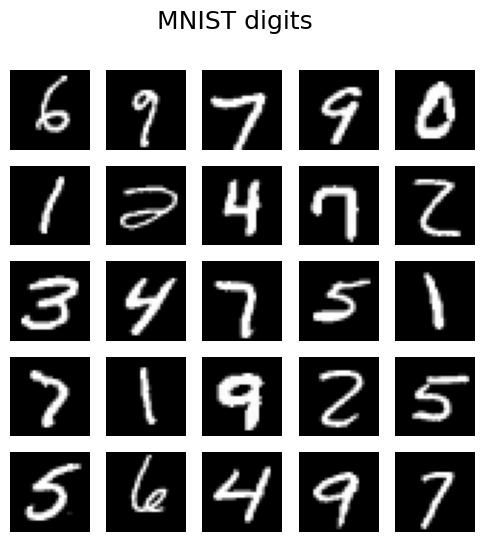

In [4]:
# Visualize dataset
U.visualize_dataset(ds_train, "MNIST digits", n_samples=25)

### Build model

In [5]:
latent_dim = 2
encoder = M.create_conv_encoder(input_shape=(28, 28, 1), latent_dim=latent_dim)
decoder = M.create_conv_decoder(latent_dim=latent_dim)
model = M.VAE(encoder, decoder)
optimizer = keras.optimizers.legacy.Adam(3e-4)
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134171 (524.11 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [6]:
print(model.encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [7]:
model.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [8]:
# Loss and optimizer
# reconstruction_loss = keras.losses.MeanSquaredError()
reconstruction_loss = keras.losses.BinaryCrossentropy(
    from_logits=False,
    reduction=keras.losses.Reduction.SUM
)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)

In [9]:
# Define callback for Tensorboard and Model Checkpoint
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/vae-mnist/" + current_time,
    update_freq="epoch"
)

checkpoint_dir = os.path.join(MODELDIR, f"vae-mnist-{current_time}")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# checkpoint_filepath = os.path.join(checkpoint_dir, "weights-{epoch:02d}.hdf5")
checkpoint_filepath = os.path.join(checkpoint_dir, "weights.hdf5")
modelcp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

In [10]:
# Compile and run training
model.compile(optimizer=optimizer, loss=reconstruction_loss)
model.fit(ds_train, epochs=EPOCH, callbacks=[tensorboard_callback, modelcp_callback])

Epoch 1/30
547/547 [==============================] - 16s 28ms/step - loss: 0.1238 - reconstruction_loss: 0.0866 - kl_loss: 7.8001e-06
Epoch 2/30
547/547 [==============================] - 16s 30ms/step - loss: 0.0679 - reconstruction_loss: 0.0677 - kl_loss: 3.2183e-09
Epoch 3/30
547/547 [==============================] - 18s 32ms/step - loss: 0.0676 - reconstruction_loss: 0.0674 - kl_loss: 6.2762e-10
Epoch 4/30
547/547 [==============================] - 17s 31ms/step - loss: 0.0675 - reconstruction_loss: 0.0673 - kl_loss: 1.8090e-10
Epoch 5/30
547/547 [==============================] - 16s 30ms/step - loss: 0.0674 - reconstruction_loss: 0.0673 - kl_loss: 1.8416e-09
Epoch 6/30
547/547 [==============================] - 17s 31ms/step - loss: 0.0674 - reconstruction_loss: 0.0673 - kl_loss: 1.8154e-10
Epoch 7/30
547/547 [==============================] - 17s 31ms/step - loss: 0.0674 - reconstruction_loss: 0.0673 - kl_loss: 3.5989e-10
Epoch 8/30
547/547 [==============================] - 1